# Active Learning for Polymer Name Extraction

In this notebook we are experimenting with finding polymer names in a list of words.  The features we will use come from a word embedding model trained on the papers from which the words come.

# Imports

In [1]:
import sys
sys.path.append("/home/tando/.conda/envs/roselyne_medium/lib/python3.6/site-packages")
sys.path.append("/home/tando/active-learning")

In [2]:
import gensim
from matplotlib import pyplot as plt
import numpy as np
import re
import spacy

from sklearn.base import clone
from sklearn.metrics import f1_score
from sklearn.neighbors import KNeighborsClassifier

%matplotlib inline

In [3]:
from active_learning.utils import perform_experiment
import active_learning.query_strats as qs

In [4]:
%load_ext autoreload
%autoreload 1
%aimport active_learning

# Parameters

In [5]:
CANDIDATES_FNAME = "candidates/classifier_candidates.txt"
GROUND_TRUTH_FNAME = "ground-truth/ground_truth_list_format.txt"

base_clf = KNeighborsClassifier()

# Load data

In [6]:
# Load spacy for candidate processing
nlp = spacy.load("en")
# Adding these into the vocabulary
nlp.vocab[u"diblock"].is_stop = False
nlp.vocab[u"g/mol"].is_stop   = False
nlp.vocab[u"kg/mol"].is_stop  = False

In [7]:
# Load the pre trained gensim model
model = gensim.models.Word2Vec.load("models/gensim_cbow.bin")

# Get word vectors
word_vectors = model.wv
# Get vocab
vocabulary = list(model.wv.vocab)

In [8]:
def load_word_list(fname):
    with open(fname) as reader:
        words = reader.readlines()
        words = [w.strip() for w in words]
        return words
    
candidates = load_word_list(CANDIDATES_FNAME)
true_polymer_names = set(load_word_list(GROUND_TRUTH_FNAME))

# Preprocessing

In [9]:
FREQUENT_CONTEXT_WORDS = [
    "weight","material","system","chains","samples", "systems","Tg",
    "weights","comparison","chromatography","Mn","THF","toluene","GPC",
    "chloroform","index","Column","columns","standards","reference",
    "segments","polydispersity","substrate","block","components",
    "permeation","component","Mw","bulk","standard","calibration",
    "dynamics","cross-linked","cells","domains","segment","mixtures",
    "densities","substrates","well-defined","silica","SEC","particles",
    "compositions","surfaces","linear"
]

In [10]:
# These are polymers that could appear within spacy vocab
COMMON_POLYS = [
    'polyethylene', 'polyurethane', 'polypropylene', 'polyester', 'PS', 
    'polystyrene', 'PLA', 'PI', 'PET', 'PVP', 'PEG', 'cellulose', 'PAN', 
    'methyl'
]
COMMON_POLYS = [polymer.lower() for polymer in COMMON_POLYS] 

In [11]:
# Check if a string is a number
def is_number(n):
    try:
        float(n)
        return True
    except ValueError:
        return False

In [12]:
# First use vectors as features
def refine_candidate(candidate):
    # spaCy shouldn't contain polymer names except very common ones
    if (candidate in nlp.vocab) and candidate.lower() not in COMMON_POLYS:
        return ""
 
    # common words that appear in context of polymers without being polymers
    if candidate in FREQUENT_CONTEXT_WORDS:
        return ""
            
    junk = False
    items = re.split(' |:|;|-',candidate)
    for item in items:
        #Removing items that are sentences within  parenthesis
        if item != "poly" and \
           not is_number(item) and \
           ("standard" in item or (item in nlp.vocab and item not in COMMON_POLYS)):
            junk = True
            break

    if junk is True:
        return ""
    
    return candidate

In [13]:
# preprocess candidates to remove a few junk items
init_n_candidates = len(candidates)
candidates = [refine_candidate(c) for c in candidates]
candidates = list(filter(len, candidates)) # filter out empty strings
final_n_candidates = len(candidates)

print(f"Removed {init_n_candidates-final_n_candidates}/{final_n_candidates}")

Removed 7/13265


In [14]:
# Remove candidates that aren't in vocabulary since we cannot featurize them
init_n_candidates = len(candidates)
candidates = [c for c in candidates if c in word_vectors]
final_n_candidates = len(candidates)

print(f"Removed {init_n_candidates-final_n_candidates}/{final_n_candidates}")

Removed 13/13252


# Featurize

In [15]:
X = np.array([word_vectors[c] for c in candidates])

y = np.array([c in true_polymer_names for c in candidates], dtype=int)

# Run experiments

We will try using several different query strategies.  The baseline is `random` which amounts to randomly sampling points from the input space.  There is then `uncertainty` which queries the points with the greatest marginal entropy under the current model.  `3DS` is a slightly more complicated version of encertainty that tries to balance uncertainty with representative sampling.  `AS` is very computationally intensive, and tries to find as many examples of the positive class `(y==1)` as possible.  _N.B.: `AS` takes ~2.5 hours on an m1.medium instance_

In [19]:
init_L_size = 5  # must have at least 5 data points to fit KNN(5)

strats = {
    "random": qs.random_sampling,
    "uncertainty": qs.uncertainty_sampling,
    "3ds": qs.three_ds,
    "AS": qs.active_search
}

In [20]:
all_experiment_data = {}
for strat_name, strat in strats.items():
    print("Evaluating", strat_name)
    clf = clone(base_clf)
    experiment_data = perform_experiment(
        X, y, 
        base_estimator=clf, 
        init_L_size=init_L_size, 
        query_strat=strat,
        score_fns={"f1": f1_score},
        random_state=0,
        batch_size=1
    )
    all_experiment_data[strat_name] = experiment_data

Evaluating random
Query 0 / 40
Query 1 / 40
Query 2 / 40
Query 3 / 40
Query 4 / 40
Query 5 / 40
Query 6 / 40
Query 7 / 40
Query 8 / 40
Query 9 / 40
Query 10 / 40
Query 11 / 40
Query 12 / 40
Query 13 / 40
Query 14 / 40
Query 15 / 40


/opt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Query 16 / 40
Query 17 / 40
Query 18 / 40
Query 19 / 40
Query 20 / 40
Query 21 / 40
Query 22 / 40
Query 23 / 40
Query 24 / 40
Query 25 / 40
Query 26 / 40
Query 27 / 40
Query 28 / 40
Query 29 / 40
Query 30 / 40
Query 31 / 40
Query 32 / 40
Query 33 / 40
Query 34 / 40
Query 35 / 40
Query 36 / 40
Query 37 / 40
Query 38 / 40
Query 39 / 40
Evaluating uncertainty
Query 0 / 40
Query 1 / 40
Query 2 / 40
Query 3 / 40
Query 4 / 40
Query 5 / 40
Query 6 / 40
Query 7 / 40
Query 8 / 40


/opt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Query 9 / 40
Query 10 / 40
Query 11 / 40
Query 12 / 40
Query 13 / 40
Query 14 / 40
Query 15 / 40
Query 16 / 40
Query 17 / 40
Query 18 / 40
Query 19 / 40
Query 20 / 40
Query 21 / 40
Query 22 / 40
Query 23 / 40
Query 24 / 40
Query 25 / 40
Query 26 / 40
Query 27 / 40
Query 28 / 40
Query 29 / 40
Query 30 / 40
Query 31 / 40
Query 32 / 40
Query 33 / 40
Query 34 / 40
Query 35 / 40
Query 36 / 40
Query 37 / 40
Query 38 / 40
Query 39 / 40
Evaluating 3ds
Query 0 / 40


/opt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/tando/active-learning/active_learning/query_strats/three_ds.py:47: RuntimeWarning: divide by zero encountered in log
  log_probs = np.log(probs)
/home/tando/active-learning/active_learning/query_strats/three_ds.py:58: RuntimeWarning: invalid value encountered in multiply
  x = U[np.argmax((1-eps) * (1-distances) + eps * densities)]


Query 1 / 40
Query 2 / 40
Query 3 / 40
Query 4 / 40
Query 5 / 40
Query 6 / 40
Query 7 / 40
Query 8 / 40
Query 9 / 40
Query 10 / 40
Query 11 / 40
Query 12 / 40
Query 13 / 40
Query 14 / 40
Query 15 / 40
Query 16 / 40
Query 17 / 40
Query 18 / 40
Query 19 / 40
Query 20 / 40
Query 21 / 40
Query 22 / 40
Query 23 / 40
Query 24 / 40
Query 25 / 40
Query 26 / 40
Query 27 / 40
Query 28 / 40
Query 29 / 40
Query 30 / 40
Query 31 / 40
Query 32 / 40
Query 33 / 40
Query 34 / 40
Query 35 / 40
Query 36 / 40
Query 37 / 40
Query 38 / 40
Query 39 / 40
Evaluating AS
Query 0 / 40


/opt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Query 1 / 40


/opt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Query 2 / 40


/opt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Query 3 / 40


/opt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Query 4 / 40


/opt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Query 5 / 40
Query 6 / 40
Query 7 / 40
Query 8 / 40
Query 9 / 40
Query 10 / 40
Query 11 / 40
Query 12 / 40
Query 13 / 40
Query 14 / 40
Query 15 / 40
Query 16 / 40
Query 17 / 40
Query 18 / 40
Query 19 / 40
Query 20 / 40
Query 21 / 40
Query 22 / 40
Query 23 / 40
Query 24 / 40
Query 25 / 40
Query 26 / 40
Query 27 / 40
Query 28 / 40
Query 29 / 40
Query 30 / 40
Query 31 / 40
Query 32 / 40
Query 33 / 40
Query 34 / 40
Query 35 / 40
Query 36 / 40
Query 37 / 40
Query 38 / 40
Query 39 / 40


# Plots

Plots a couple of different measures of success over time.

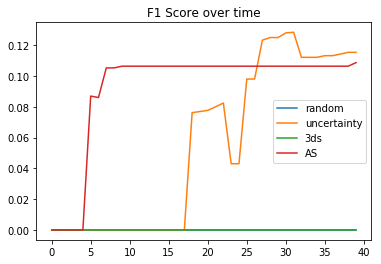

In [23]:
for name, exp_data in all_experiment_data.items():
    f1_scores = exp_data["f1"]
    x = np.arange(len(f1_scores))
    plt.plot(x, f1_scores, label=name)
    
plt.title("F1 Score over time")
plt.legend()

plt.savefig("F1_score.png")

This is a little surprising that 3ds fails so spectacularly.  Random makes sense because the ratio of targets/non targets is so small, we could easily smaple 40 random elements without getting a single target, meaning our F1 is undefined (= 0.0).

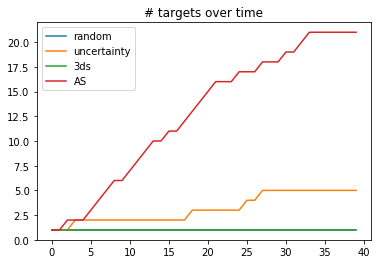

In [24]:
for name, exp_data in all_experiment_data.items():
    n_targets = exp_data["history"]
    x = np.arange(len(n_targets))
    plt.plot(x, n_targets, label=name)
    
plt.title("# targets over time")
plt.legend()

plt.savefig("num_targets.png")

This is even more surprising!  We see a good rate of target acquisition using simple uncertainty sampling.  This means that a lot of the target polymers are very uncertain in the model.  Does this mean that the decision boundary is really bad?  Maybe actually many of the polymers are somehow outliers?

In [35]:
from sklearn.model_selection import train_test_split
cand_arr = np.array(candidates)
cand_train, cand_test, y_train, y_test = train_test_split(cand_arr, y, random_state=0)

exp_data = all_experiment_data["AS"]
queries = np.concatenate(exp_data["queries"])

for word, label in zip(cand_train[queries], y_train[queries]):
    print(label, word)

0 Rigorous
0 9,9-dimethylfluoren-2-boronic
1 PFS
0 nonionic
0 polycarbonate
1 PDMAEMA
1 PDMS
1 P3HT
1 PNIPAM
0 thermosets
1 PMMA
1 PtBA
1 PAA
1 PE
0 thermoresponsive
1 PLLA
0 immiscible
1 PVP
1 poly(methyl methacrylate)
1 PP
1 polyethylene
1 polypropylene
0 polyimide
0 deuterated
1 cellulose
0 oligomers
0 ionomers
1 PI
0 crystallinity
0 surfactant
1 PEO
0 lamellar
1 PCL
1 PEG
0 crystallization
0 LC
0 crystallized
0 miscible
0 copolymer
0 isotactic


# Outlier Detection

In [36]:
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM

from sklearn.metrics import f1_score, precision_score, recall_score

In [37]:
outlier_fraction = (np.sum(y==1) / len(y)) / 4

detectors = {
    "Robust covariance": EllipticEnvelope(contamination=outlier_fraction),
    "Isolation Forest": IsolationForest(contamination=outlier_fraction),
    "Local Outlier Factor": LocalOutlierFactor(n_neighbors=35, contamination=outlier_fraction)
}

In [40]:
outlier_results = pd.DataFrame(columns=["score", "n_outliers", "f1"])

ground_truth = y.copy()

for name, clf in detectors.items():
    print(name)
    if name == "Local Outlier Factor":
        outlier_labels = clf.fit_predict(X)
    else:
        clf.fit(X)
        outlier_labels = clf.predict(X)
        
    outlier_labels[outlier_labels==1] = 0
    outlier_labels[outlier_labels==-1] = 1
    
    outlier_results.loc[name] = {
        "score": np.sum(ground_truth != outlier_labels),
        "n_outliers": np.sum(outlier_labels == 1),
        "f1": f1_score(ground_truth, outlier_labels)
    }
    
outlier_results

Robust covariance
Isolation Forest
Local Outlier Factor


,score,n_outliers,f1
Robust covariance,387.0,82.0,0.049140
Isolation Forest,393.0,82.0,0.034398
Local Outlier Factor,405.0,82.0,0.004914


# Sanity model selection

In [39]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, accuracy_score, recall_score

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [49]:
classifiers = {
    "Decision Tree": DecisionTreeClassifier(),
    "Gradient Boosting Classifier": GradientBoostingClassifier(n_estimators=500),
    "KNN(uniform)": KNeighborsClassifier(weights="uniform"),
    "KNN(distance)": KNeighborsClassifier(weights="distance"),
    "Logistic Regression": LogisticRegression(),
    "Linear SVM": LinearSVC(),
    "Neural Net": MLPClassifier(alpha = 1),
    "Naive Bayes": GaussianNB(),    
    "Random Forest": RandomForestClassifier(n_estimators=500)
}

NameError: name 'VotingClassifier' is not defined

In [18]:
clf_results = pd.DataFrame(columns=["F1", "precision", "recall", "accuracy"])

for name, clf in classifiers.items():
    print(name)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    
    results.loc[name] = {
        "F1": f1_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred),
        "accuracy": accuracy_score(y_test, y_pred),
        "recall": recall_score(y_test, y_pred)
    }
    
results

Decision Tree
Gradient Boosting Classifier
KNN(uniform)
KNN(distance)
Logistic Regression
Linear SVM
Neural Net
Naive Bayes
Random Forest
SVC


,F1,precision,recall,accuracy
Decision Tree,0.181818,0.162393,0.206522,0.948385
Gradient Boosting Classifier,0.180180,0.526316,0.108696,0.972532
KNN(uniform),0.220183,0.705882,0.130435,0.974343
KNN(distance),0.252252,0.736842,0.152174,0.974947
Logistic Regression,0.114286,0.461538,0.065217,0.971929
Linear SVM,0.115385,0.500000,0.065217,0.972231
Neural Net,0.082474,0.800000,0.043478,0.973136
Naive Bayes,0.051948,0.034130,0.108696,0.889828
Random Forest,0.101010,0.714286,0.054348,0.973136
SVC,0.062500,0.750000,0.032609,0.972834


# Clustering Tests

In [29]:
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering, DBSCAN, Birch
from sklearn.metrics import silhouette_score

In [58]:
clusterers = {
    "KMeans": KMeans(n_clusters=2),
    "Birch+KMeans": Birch(n_clusters=KMeans(n_clusters=2)),
    "Birch": Birch(n_clusters=2)
}

In [59]:
clst_results = pd.DataFrame(columns=["silhouette", "0", "1"])
for name, clst in clusterers.items():
    print(name)
    
#     clst.fit(X)
    
    y_pred = clst.fit_predict(X)
    
    clst_results.loc[name] = {
        "silhouette": silhouette_score(X, y_pred),
        "0": np.sum(y_pred==0),
        "1": np.sum(y_pred==1)
    }
    
clst_results

KMeans
Birch+KMeans
Birch


,silhouette,0,1
KMeans,0.708610,732.0,12520.0
Birch+KMeans,0.802549,13019.0,233.0
Birch,0.867393,13213.0,39.0


In [78]:
clusterer = Birch(n_clusters=KMeans(n_clusters=2))
clusterer.fit(X)
pred_labels = clusterer.predict(X)
pred_labels = pred_labels.reshape(-1, 1)

X_aug = np.hstack([X, pred_labels])

X_aug_train, X_aug_test, X_unaug_train, X_unaug_test, y_aug_train, y_aug_test = train_test_split(X_aug, X, y)

# clf = KNeighborsClassifier(weights="distance")
clf = GradientBoostingClassifier(n_estimators=500)
clf.fit(X_aug_train, y_aug_train)
y_aug_pred = clf.predict(X_aug_test)
print("F1 Augmented:", f1_score(y_aug_test, y_aug_pred))

# clf = KNeighborsClassifier(weights="distance")
clf = GradientBoostingClassifier(n_estimators=500)
clf.fit(X_unaug_train, y_aug_train)
y_unaug_pred = clf.predict(X_unaug_test)
print("F1 Unaugmented:", f1_score(y_aug_test, y_unaug_pred))

F1 Augmented: 0.2247191011235955
F1 UNaugmented: 0.2247191011235955


In [67]:
X_aug_train.shape

(9939, 101)

In [77]:
y[(pred_labels.reshape(-1) != y)].sum()

325